In [27]:
#package imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn import datasets
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')

In [2]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

In [3]:
# Look at fields used in the test data
test_data.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [4]:
# Store the columns that are usable for the predictions
test_features = list(test_data.columns)

In [5]:
# Split data and set the appropriate columns
test_features = list(test_data.columns)

Y = training_data['requester_received_pizza']
X = training_data[training_data.columns[training_data.columns.isin(test_features)]]

train_data, train_labels = X[:3609], Y[:3609]
val_data, val_labels = X[3609:], Y[3609:]

In [6]:
train_data, train_labels = X[:3609], Y[:3609]
val_data, val_labels = X[3609:], Y[3609:]

In [7]:
train_requests = train_data['request_text_edit_aware'].str.lower().tolist()

In [8]:
val_requests = val_data['request_text_edit_aware'].str.lower().tolist()

In [9]:
money = ['money',
        'rent',
        'broke',
        'paid',
        'spent',
        'rent',
        'bills',
        'paycheck',
        'accident']

hunger = ['food',
        'hungry',
        'starving',
        'starve',
        'empty',
        'ramen',
        'nothing']

unemployed = ['job',
            'work',
            'unemployed' ]

gratitude = ['thanks',
             'kind',
             'pay it forward',
             'give back']

In [10]:
def encode_one_hot(text, data):
    one_hot = []
    requests = data['request_text_edit_aware'].str.lower().tolist()
    
    for i in range(len(data)):
        check = []

        for word in text:
            if word in requests[i]:
                check.append(True)
                break
            else:
                check.append(False)
            
        if any(check):
            one_hot.append(1)
        else:
            one_hot.append(0)

    
    return one_hot

In [11]:
train_requests[1]

'i spent the last money i had on gas today. im broke until next thursday :('

In [12]:
money_req = encode_one_hot(money, train_data)
train_data['money'] = money_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/110263446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['money'] = money_req


In [13]:
hunger_req = encode_one_hot(hunger, train_data)
train_data['hungry'] = hunger_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/2321378634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['hungry'] = hunger_req


In [14]:
unemployed_req = encode_one_hot(unemployed, train_data)
train_data['job'] = unemployed_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/1521911453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['job'] = unemployed_req


In [15]:
gratitude_req = encode_one_hot(gratitude, train_data)
train_data['thanks'] = gratitude_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/2111369362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['thanks'] = gratitude_req


In [16]:
train_data

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,money,hungry,job,thanks
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,0.000000,0,0,0,0,...,[],0,0,nickylvst,1317852607,1317849007,0,1,0,0
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,0.000000,0,0,15,0,...,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1332652424,1332648824,1,0,0,0
2,N/A,t3_lpu5j,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,0.000000,0,0,0,0,...,[],0,0,jacquibatman7,1319650094,1319646494,1,0,0,1
3,N/A,t3_mxvj3,"It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,0.000000,36,0,1,0,...,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,76,4on_the_floor,1322855434,1322855434,1,1,0,0
4,N/A,t3_1i6486,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,101.606505,140,2,14,0,...,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1733,Futuredogwalker,1373657691,1373654091,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,N/A,t3_hucws,Hello!\nI've been unemployed since February an...,[REQUEST] Me and my girlfriend would like some...,495.540926,0.000000,341,0,6,0,...,"[Android, AskReddit, Drugs, IAmA, LSD, Marijua...",786,1478,dxtrr,1307511169,1307507569,1,0,1,1
3605,N/A,t3_rgg9c,"It is a dreadful rainy day in Chico, and I hav...","[REQUEST] (Chico,CA) I'd make good use of a Do...",39.031748,39.031748,1,1,0,0,...,[Random_Acts_Of_Pizza],1,1,danhalligan,1332886852,1332883252,1,1,0,0
3606,N/A,t3_ko99d,I haven't slept in 2 weeks. I discovered those...,[REQUEST] Pizza for the sleepy,641.276516,0.000000,368,0,16,0,...,"[AMA, AdviceAnimals, Art, AskReddit, DIY, Desi...",2091,3653,borg484,1316725413,1316721813,1,0,1,1
3607,N/A,t3_1ixzy0,I moved in with my grandma in Seattle who does...,[Request] Haven't eaten much this week. Also v...,95.992164,0.000000,38,0,1,0,...,"[AdviceAnimals, AskReddit, OFWGKTA, WTF, athei...",129,193,xPostScriptx,1374655931,1374652331,1,1,1,0


In [17]:
money_req = encode_one_hot(money, val_data)
val_data['money'] = money_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/78943957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['money'] = money_req


In [18]:
hunger_req = encode_one_hot(hunger, val_data)
val_data['hungry'] = hunger_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/777056464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['hungry'] = hunger_req


In [19]:
unemployed_req = encode_one_hot(unemployed, val_data)
val_data['job'] = unemployed_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/2529158533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['job'] = unemployed_req


In [20]:
gratitude_req = encode_one_hot(gratitude, val_data)
val_data['thanks'] = gratitude_req

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_49166/976044967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['thanks'] = gratitude_req


In [21]:
tree_features = ['requester_account_age_in_days_at_request',
                'requester_number_of_comments_in_raop_at_request',
                'requester_upvotes_plus_downvotes_at_request',
                'money',
                'hungry',
                'thanks',
                'job']

In [22]:
val_data

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,money,hungry,job,thanks
3609,N/A,t3_1l0ugy,"Hey guys, my summer campus job just ended and ...",[Request] Broke until my new job starts in a week,500.034468,95.836285,499,0,25,1,...,"[AdviceAnimals, Art, AskReddit, C25K, Entrepre...",6119,11191,CloudDrunk,1377383919,1377380319,1,1,1,0
3610,N/A,t3_1kty6v,,[REQUEST] Broke as a joke. Want to give my gir...,69.929641,14.139815,79,2,10,0,...,"[4chan, AdviceAnimals, AskReddit, ClimbingCirc...",134,382,Dallas_Corbin,1377124534,1377120934,0,0,0,0
3611,N/A,t3_jxqv7,My Girlfriend doesn't believe there are actual...,[REQUEST] Pwn my Hot Girlfriend for a pizza...,0.000000,0.000000,0,0,0,0,...,[],0,0,lulz1337,1314603625,1314600025,0,0,1,0
3612,N/A,t3_ojq68,Been subsisting on friends generosity and a ba...,"[Request] [usa] Broke, can't seem to find a jo...",61.186620,0.131713,9,1,2,0,...,"[AskReddit, Random_Acts_Of_Pizza, WTF, pics, v...",195,363,beencaughtfapping,1326745487,1326745487,0,0,0,0
3613,N/A,t3_11yryj,would love a pizza. pm me if you wanna be kind :D,"[REQUEST] Birmingham,UK",0.139433,0.000000,0,0,1,0,...,[GiftofGames],1,11,PresidentGaryJohnson,1351028074,1351024474,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4035,N/A,t3_1hpv57,Is anyone out there kind enough to help me out...,[REQUEST] Anyone help a recent college grad wh...,0.000000,0.000000,0,0,0,0,...,[],0,0,bstewart88,1373068818,1373065218,1,1,1,1
4036,N/A,t3_1lzcwr,If someone could hook me up with a $15 gift ca...,[Request][USA] Papa Johns is giving away one f...,658.366863,638.983264,50,4,9,0,...,"[AskReddit, CoffeeWithJesus, IAmA, RandomKindn...",738,2974,puddems,1378667174,1378663574,0,0,0,1
4037,N/A,t3_1f77ml,"Have today off, soo I'll be stuck in the house...","[REQUEST][MI,USA] Day off, would love pizza fo...",410.551736,0.000000,61,0,6,0,...,"[AdviceAnimals, Android, AskReddit, Diablo, HT...",1252,5634,Candlejac88,1369754714,1369751114,0,1,1,0
4038,N/A,t3_q875f,"I've never done anything like this before, but...",[Request] Nashua Nh Mother of one hungry 2 yea...,0.000000,0.000000,0,0,0,0,...,[Random_Acts_Of_Pizza],5,7,nhcollegechic,1330357920,1330357920,1,1,0,0


In [23]:
train_data.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc', 'money',
       'hungry', 'job', 'thanks'],
      dtype='object')

In [24]:
tr_train = train_data[train_data.columns[train_data.columns.isin(tree_features)]]
tr_val = val_data[val_data.columns[val_data.columns.isin(tree_features)]]

Using a decision stump -- a tree with depth 1:
Feature importances: [0.10316859 0.35098923 0.30839241 0.18026388 0.05718588 0.
 0.        ]
Accuracy: 0.7563805104408353


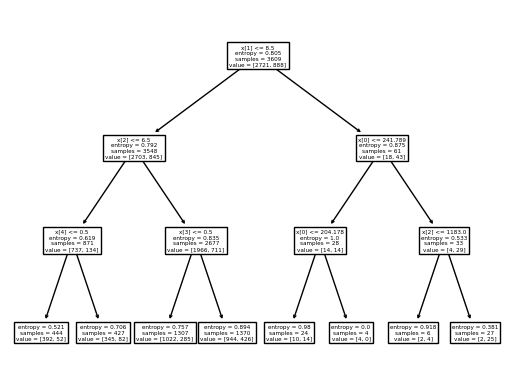

In [25]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dt.fit(tr_train, train_labels)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(tr_val, val_labels))

In [32]:
forest = RandomForestClassifier(n_estimators = 20)

forest.fit(tr_train, train_labels)

RandomForestClassifier(n_estimators=20)

In [33]:
print ('Accuracy:', forest.score(tr_train, train_labels))

Accuracy: 0.9598226655583264


In [34]:
print ('Accuracy:', forest.score(tr_val, val_labels))

Accuracy: 0.7215777262180975
